In [2]:
#!pip install pandas
#%matplotlib inline
import math
import numpy as np
import pandas as pd
import pandasql as ps
import scipy.stats as stats
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
import IPython.display as ipd

import ast

import utils

from collections import defaultdict
from scipy.stats.stats import pearsonr

plt.rcParams['axes.formatter.useoffset']=False
pd.set_option('display.max_columns', None)

In [3]:
echonest = pd.read_csv('fma_metadata_progetto/echonest.csv', index_col=0, header=[0, 1, 2])
features = pd.read_csv('fma_metadata_progetto/features.csv', index_col=0, header=[0, 1, 2])
genres = pd.read_csv('fma_metadata_progetto/genres.csv', index_col=0)
tracks = pd.read_csv('fma_metadata_progetto/tracks.csv', index_col=0, header=[0, 1])

#raw_albums = pd.read_csv('fma_metadata_progetto/raw_albums.csv')
#raw_artists = pd.read_csv('fma_metadata_progetto/raw_artists.csv')
#raw_echonest = pd.read_csv('fma_metadata_progetto/raw_echonest.csv')
#raw_generes = pd.read_csv('fma_metadata_progetto/raw_genres.csv')
#raw_tracks = pd.read_csv('fma_metadata_progetto/raw_tracks.csv')


COLUMNS = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),
                   ('track', 'genres'), ('track', 'genres_all')]
for column in COLUMNS:
    tracks[column] = tracks[column].map(ast.literal_eval)

COLUMNS = [('track', 'date_created'), ('track', 'date_recorded'),
           ('album', 'date_created'), ('album', 'date_released'),
           ('artist', 'date_created'), ('artist', 'active_year_begin'),
           ('artist', 'active_year_end')]
for column in COLUMNS:
    tracks[column] = pd.to_datetime(tracks[column])

SUBSETS = ('small', 'medium', 'large')
try:
    cat_type = CategoricalDtype(categories=SUBSETS, ordered=True)
    tracks['set', 'subset'] = tracks['set', 'subset'].astype(cat_type)
except ValueError:
    # the categories and ordered arguments were removed in pandas 0.25
    tracks['set', 'subset'] = tracks['set', 'subset'].astype(
             pd.CategoricalDtype(categories=SUBSETS, ordered=True))

COLUMNS = [('track', 'genre_top'), ('track', 'license'),
           ('album', 'type'), ('album', 'information'),
           ('artist', 'bio')]
for column in COLUMNS:
    tracks[column] = tracks[column].astype('category')

In [52]:
echonest.head()

echonest                                                    \
         audio_features                                                     
           acousticness danceability    energy instrumentalness  liveness   
track_id                                                                    
2              0.416675     0.675894  0.634476         0.010628  0.177647   
3              0.374408     0.528643  0.817461         0.001851  0.105880   
5              0.043567     0.745566  0.701470         0.000697  0.373143   
10             0.951670     0.658179  0.924525         0.965427  0.115474   
134            0.452217     0.513238  0.560410         0.019443  0.096567   

                                                                        \
                                           metadata                      
         speechiness    tempo   valence  album_date         album_name   
track_id                                                                 
2           0.159310  165.922  0.576661         NaN                NaN   
3           0.461818  126.957  0.269240         NaN                NaN   
5           0.124595  100.260  0.621661         NaN                NaN   
10          0.032985  111.562  0.963590  2008-03-11  Constant Hitmaker   
134         0.525519  114.290  0.894072         NaN                NaN   

                                                                             \
                                                                              
         artist_latitude       artist_location artist_longitude artist_name   
track_id                                                                      
2                32.6783           Georgia, US         -83.2230        AWOL   
3                32.6783           Georgia, US         -83.2230        AWOL   
5                32.6783           Georgia, US         -83.2230        AWOL   
10               39.9523  Philadelphia, PA, US         -75.1624   Kurt Vile   
134              32.6783           Georgia, US         -83.2230        AWOL   

                                                                              \
                                               ranks                           
                       release artist_discovery_rank artist_familiarity_rank   
track_id                                                                       
2         AWOL - A Way Of Life                   NaN                     NaN   
3         AWOL - A Way Of Life                   NaN                     NaN   
5         AWOL - A Way Of Life                   NaN                     NaN   
10           Constant Hitmaker                2635.0                  2544.0   
134       AWOL - A Way Of Life                   NaN                     NaN   

                                                                         \
                                                                          
         artist_hotttnesss_rank song_currency_rank song_hotttnesss_rank   
track_id                                                                  
2                           NaN                NaN                  NaN   
3                           NaN                NaN                  NaN   
5                           NaN                NaN                  NaN   
10                        397.0           115691.0              67609.0   
134                         NaN                NaN                  NaN   

                                                                              \
          social_features                                                      
         artist_discovery artist_familiarity artist_hotttnesss song_currency   
track_id                                                                       
2                0.388990           0.386740          0.406370      0.000000   
3                0.388990           0.386740          0.406370      0.000000   
5                0.388990           0.386740          0.406370   

artist_discovery


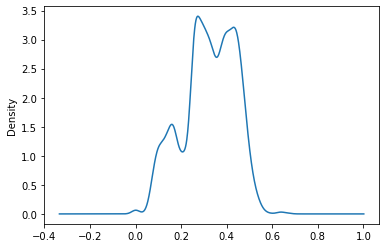

artist_familiarity


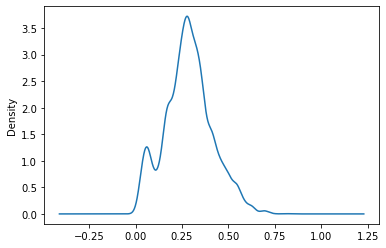

artist_hotttnesss


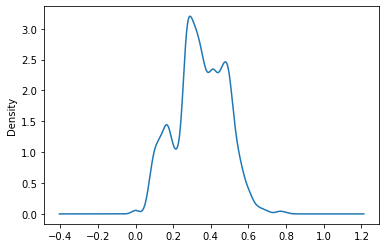

song_currency


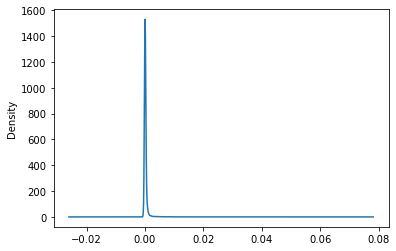

song_hotttnesss


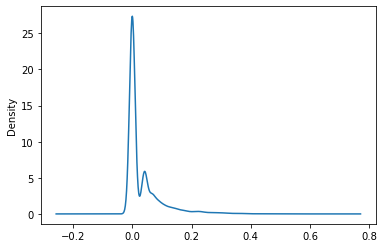

In [61]:
for el in echonest.echonest.social_features.columns:
    print(el)
    echonest.echonest.social_features[el].plot(kind="kde")
    plt.show()

In [5]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106574 entries, 2 to 155320
Columns: 518 entries, ('chroma_cens', 'kurtosis', '01') to ('zcr', 'std', '01')
dtypes: float64(518)
memory usage: 422.0 MB


In [6]:
genres.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163 entries, 1 to 1235
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   #tracks    163 non-null    int64 
 1   parent     163 non-null    int64 
 2   title      163 non-null    object
 3   top_level  163 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.4+ KB


In [7]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106574 entries, 2 to 155320
Data columns (total 52 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   (album, comments)            106574 non-null  int64         
 1   (album, date_created)        103045 non-null  datetime64[ns]
 2   (album, date_released)       70294 non-null   datetime64[ns]
 3   (album, engineer)            15295 non-null   object        
 4   (album, favorites)           106574 non-null  int64         
 5   (album, id)                  106574 non-null  int64         
 6   (album, information)         83149 non-null   category      
 7   (album, listens)             106574 non-null  int64         
 8   (album, producer)            18060 non-null   object        
 9   (album, tags)                106574 non-null  object        
 10  (album, title)               105549 non-null  object        
 11  (album, tracks)           

In [8]:
tracks.album.head()

,comments,date_created,date_released,engineer,favorites,id,information,listens,producer,tags,title,tracks,type
track_id,,,,,,,,,,,,,
2,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
3,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
5,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
10,0,2008-11-26 01:45:08,2008-02-06,NaN,4,6,NaN,47632,NaN,[],Constant Hitmaker,2,Album
20,0,2008-11-26 01:45:05,2009-01-06,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,[],Niris,13,Album


In [9]:
tracks.artist.head()

,active_year_begin,active_year_end,associated_labels,bio,comments,date_created,favorites,id,latitude,location,longitude,members,name,related_projects,tags,website,wikipedia_page
track_id,,,,,,,,,,,,,,,,,
2,2006-01-01,NaT,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,[awol],http://www.AzillionRecords.blogspot.com,NaN
3,2006-01-01,NaT,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,[awol],http://www.AzillionRecords.blogspot.com,NaN
5,2006-01-01,NaT,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,[awol],http://www.AzillionRecords.blogspot.com,NaN
10,NaT,NaT,"Mexican Summer, Richie Records, Woodsist, Skul...","<p><span style=""font-family:Verdana, Geneva, A...",3,2008-11-26 01:42:55,74,6,NaN,NaN,NaN,"Kurt Vile, the Violators",Kurt Vile,NaN,"[philly, kurt vile]",http://kurtvile.com,NaN
20,1990-01-01,2011-01-01,NaN,<p>Songs written by: Nicky Cook</p>\n<p>VOCALS...,2,2008-11-26 01:42:52,10,4,51.895927,Colchester England,0.891874,Nicky Cook\n,Nicky Cook,NaN,"[instrumentals, experimental pop, post punk, e...",NaN,NaN


In [10]:
tracks.set.head()

,split,subset
track_id,,
2,training,small
3,training,medium
5,training,small
10,training,small
20,training,large


In [11]:
tracks.track.head()

,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,genres_all,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
track_id,,,,,,,,,,,,,,,,,,,,
2,256000,0,NaN,2008-11-26 01:48:12,2008-11-26,168,2,Hip-Hop,[21],[21],NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
3,256000,0,NaN,2008-11-26 01:48:14,2008-11-26,237,1,Hip-Hop,[21],[21],NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
5,256000,0,NaN,2008-11-26 01:48:20,2008-11-26,206,6,Hip-Hop,[21],[21],NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
10,192000,0,Kurt Vile,2008-11-25 17:49:06,2008-11-26,161,178,Pop,[10],[10],NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
20,256000,0,NaN,2008-11-26 01:48:56,2008-01-01,311,0,NaN,"[76, 103]","[17, 10, 76, 103]",NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level


In [12]:
echonest.head()

echonest                                                    \
         audio_features                                                     
           acousticness danceability    energy instrumentalness  liveness   
track_id                                                                    
2              0.416675     0.675894  0.634476         0.010628  0.177647   
3              0.374408     0.528643  0.817461         0.001851  0.105880   
5              0.043567     0.745566  0.701470         0.000697  0.373143   
10             0.951670     0.658179  0.924525         0.965427  0.115474   
134            0.452217     0.513238  0.560410         0.019443  0.096567   

                                                                        \
                                           metadata                      
         speechiness    tempo   valence  album_date         album_name   
track_id                                                                 
2           0.159310  165.922  0.576661         NaN                NaN   
3           0.461818  126.957  0.269240         NaN                NaN   
5           0.124595  100.260  0.621661         NaN                NaN   
10          0.032985  111.562  0.963590  2008-03-11  Constant Hitmaker   
134         0.525519  114.290  0.894072         NaN                NaN   

                                                                             \
                                                                              
         artist_latitude       artist_location artist_longitude artist_name   
track_id                                                                      
2                32.6783           Georgia, US         -83.2230        AWOL   
3                32.6783           Georgia, US         -83.2230        AWOL   
5                32.6783           Georgia, US         -83.2230        AWOL   
10               39.9523  Philadelphia, PA, US         -75.1624   Kurt Vile   
134              32.6783           Georgia, US         -83.2230        AWOL   

                                                                              \
                                               ranks                           
                       release artist_discovery_rank artist_familiarity_rank   
track_id                                                                       
2         AWOL - A Way Of Life                   NaN                     NaN   
3         AWOL - A Way Of Life                   NaN                     NaN   
5         AWOL - A Way Of Life                   NaN                     NaN   
10           Constant Hitmaker                2635.0                  2544.0   
134       AWOL - A Way Of Life                   NaN                     NaN   

                                                                         \
                                                                          
         artist_hotttnesss_rank song_currency_rank song_hotttnesss_rank   
track_id                                                                  
2                           NaN                NaN                  NaN   
3                           NaN                NaN                  NaN   
5                           NaN                NaN                  NaN   
10                        397.0           115691.0              67609.0   
134                         NaN                NaN                  NaN   

                                                                              \
          social_features                                                      
         artist_discovery artist_familiarity artist_hotttnesss song_currency   
track_id                                                                       
2                0.388990           0.386740          0.406370      0.000000   
3                0.388990           0.386740          0.406370      0.000000   
5                0.388990           0.386740          0.406370   

In [13]:
echonest[('echonest', 'audio_features')].acousticness

track_id
2         0.416675
3         0.374408
5         0.043567
10        0.951670
134       0.452217
            ...   
124857    0.007592
124862    0.041498
124863    0.000124
124864    0.327576
124911    0.993606
Name: acousticness, Length: 13129, dtype: float64

In [14]:
echonest.describe()

echonest                                               \
      audio_features                                                
        acousticness  danceability        energy instrumentalness   
count   1.312900e+04  13129.000000  13129.000000     13129.000000   
mean    5.246876e-01      0.487290      0.537516         0.640536   
std     3.837186e-01      0.190148      0.278049         0.361430   
min     9.035000e-07      0.051307      0.000020         0.000000   
25%     1.037726e-01      0.344759      0.321300         0.323466   
50%     5.739848e-01      0.485635      0.549113         0.838134   
75%     9.207270e-01      0.629094      0.776254         0.918244   
max     9.957965e-01      0.968645      0.999964         0.998016   

                                                                               \
                                                                     metadata   
           liveness   speechiness         tempo       valence artist_latitude   
count  13129.000000  13129.000000  13129.000000  13129.000000     9770.000000   
mean       0.187804      0.099174    123.080061      0.439761       39.961892   
std        0.158051      0.137381     35.015137      0.276028       15.554275   
min        0.025297      0.022324     12.753000      0.000010      -45.867100   
25%        0.101406      0.036932     95.967000      0.197321       37.784827   
50%        0.119002      0.049019    120.057000      0.417743       40.781400   
75%        0.211041      0.085452    145.318000      0.665575       47.254575   
max        0.980330      0.966177    251.072000      0.999990       68.927500   

                                                                      \
                                       ranks                           
      artist_longitude artist_discovery_rank artist_familiarity_rank   
count      9770.000000          2.825000e+03            2.825000e+03   
mean        -49.984040          2.111136e+05            1.446907e+05   
std          59.377974          3.194601e+05            2.199230e+05   
min        -155.434000          4.310000e+02            7.300000e+01   
25%         -87.632400          3.443300e+04            2.074900e+04   
50%         -74.007100          7.610300e+04            6.655200e+04   
75%          -0.127140          2.225870e+05            1.595890e+05   
max         174.770000          1.670147e+06            1.897432e+06   

                                                                      \
                                                                       
      artist_hotttnesss_rank song_currency_rank song_hotttnesss_rank   
count           2.824000e+03       2.033000e+03         2.206000e+03   
mean            2.341483e+05       2.919776e+06         2.325537e+06   
std             4.112605e+05       1.974510e+06         1.827741e+06   
min             3.970000e+02       1.283600e+04         3.857000e+03   
25%             2.604900e+04       9.122930e+05         8.171240e+05   
50%             6.179600e+04       3.445797e+06         1.873470e+06   
75%             2.223732e+05       4.620654e+06         3.423690e+06   
max             2.151407e+06       6.137419e+06         6.647230e+06   

                                                                           \
       social_features                                                      
      artist_discovery artist_familiarity artist_hotttnesss song_currency   
count     13129.000000       13129.000000      13129.000000  13129.000000   
mean          0.321996           0.286287          0.346769      0.000234   
std           0.114619           0.128304          0.133279      0.001474   
min           0.000000           0.000000          0.000000      0.000000   
25%           0.254517           0.205872          0.265889      0.000000   
50%           0.328672           0.284111          0.343653      0.000000   
75%           0.414481           0.359271          0.451625      0.000100   
max 

In [15]:
echonest.head()

echonest                                                    \
         audio_features                                                     
           acousticness danceability    energy instrumentalness  liveness   
track_id                                                                    
2              0.416675     0.675894  0.634476         0.010628  0.177647   
3              0.374408     0.528643  0.817461         0.001851  0.105880   
5              0.043567     0.745566  0.701470         0.000697  0.373143   
10             0.951670     0.658179  0.924525         0.965427  0.115474   
134            0.452217     0.513238  0.560410         0.019443  0.096567   

                                                                        \
                                           metadata                      
         speechiness    tempo   valence  album_date         album_name   
track_id                                                                 
2           0.159310  165.922  0.576661         NaN                NaN   
3           0.461818  126.957  0.269240         NaN                NaN   
5           0.124595  100.260  0.621661         NaN                NaN   
10          0.032985  111.562  0.963590  2008-03-11  Constant Hitmaker   
134         0.525519  114.290  0.894072         NaN                NaN   

                                                                             \
                                                                              
         artist_latitude       artist_location artist_longitude artist_name   
track_id                                                                      
2                32.6783           Georgia, US         -83.2230        AWOL   
3                32.6783           Georgia, US         -83.2230        AWOL   
5                32.6783           Georgia, US         -83.2230        AWOL   
10               39.9523  Philadelphia, PA, US         -75.1624   Kurt Vile   
134              32.6783           Georgia, US         -83.2230        AWOL   

                                                                              \
                                               ranks                           
                       release artist_discovery_rank artist_familiarity_rank   
track_id                                                                       
2         AWOL - A Way Of Life                   NaN                     NaN   
3         AWOL - A Way Of Life                   NaN                     NaN   
5         AWOL - A Way Of Life                   NaN                     NaN   
10           Constant Hitmaker                2635.0                  2544.0   
134       AWOL - A Way Of Life                   NaN                     NaN   

                                                                         \
                                                                          
         artist_hotttnesss_rank song_currency_rank song_hotttnesss_rank   
track_id                                                                  
2                           NaN                NaN                  NaN   
3                           NaN                NaN                  NaN   
5                           NaN                NaN                  NaN   
10                        397.0           115691.0              67609.0   
134                         NaN                NaN                  NaN   

                                                                              \
          social_features                                                      
         artist_discovery artist_familiarity artist_hotttnesss song_currency   
track_id                                                                       
2                0.388990           0.386740          0.406370      0.000000   
3                0.388990           0.386740          0.406370      0.000000   
5                0.388990           0.386740          0.406370   

In [16]:
genres.head()

,#tracks,parent,title,top_level
genre_id,,,,
1,8693,38,Avant-Garde,38
2,5271,0,International,2
3,1752,0,Blues,3
4,4126,0,Jazz,4
5,4106,0,Classical,5


## Albero dei generi

Genere con id: 38


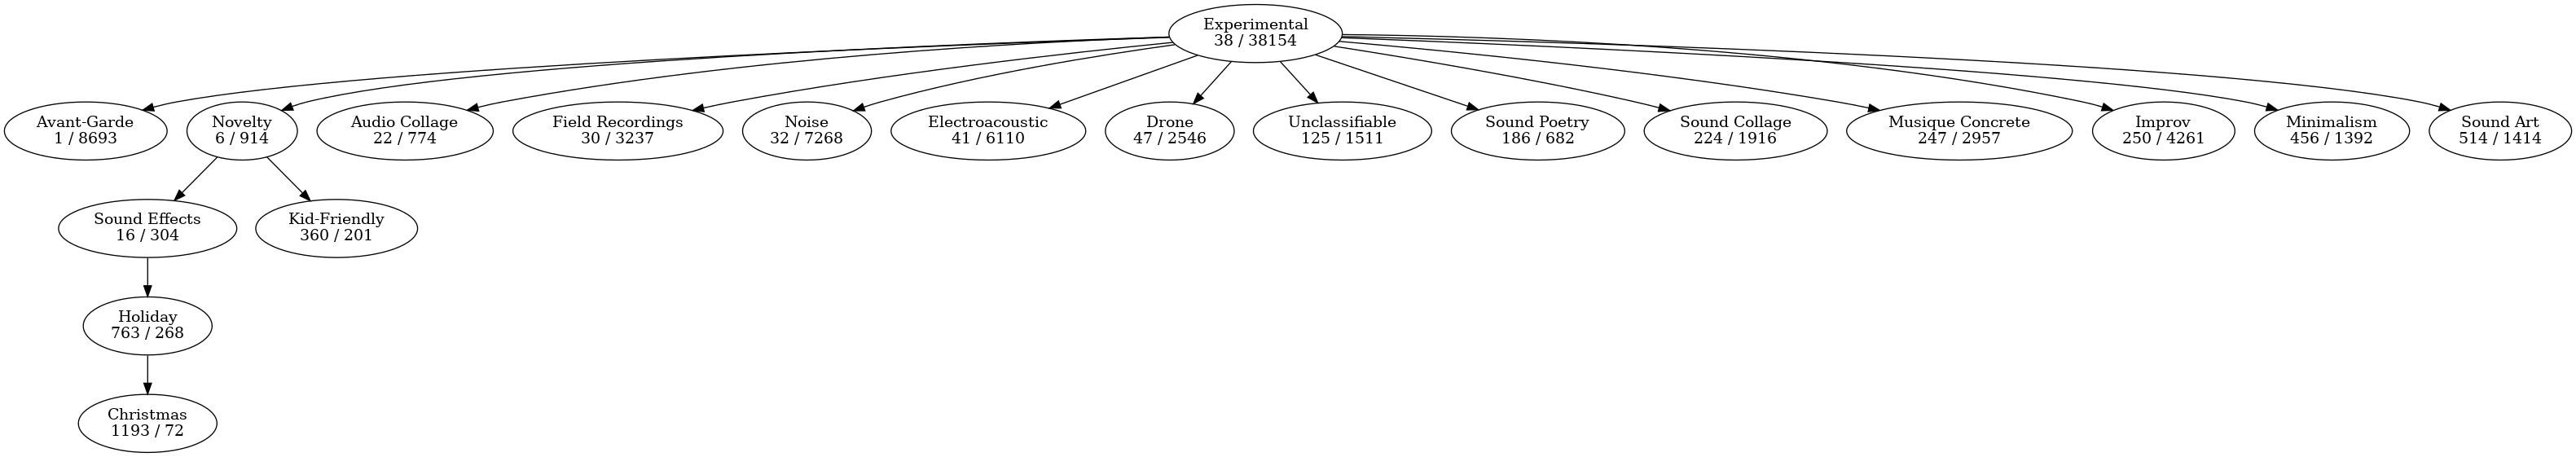

Genere con id: 2


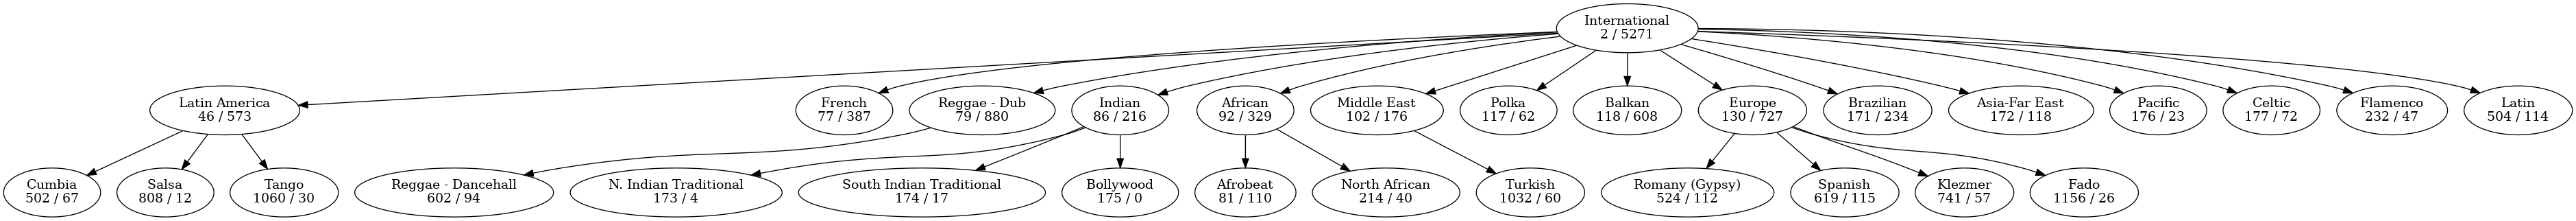

Genere con id: 3


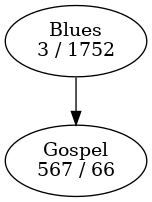

Genere con id: 4


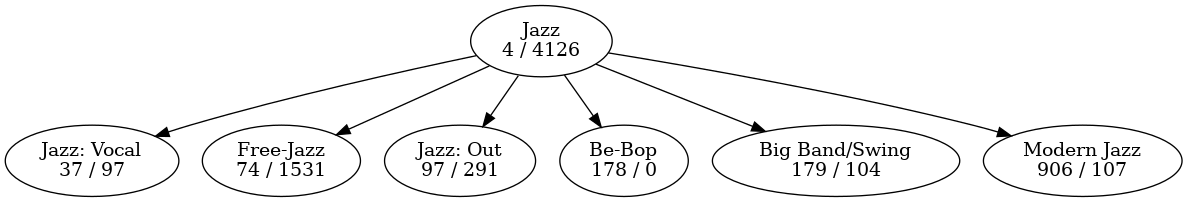

Genere con id: 5


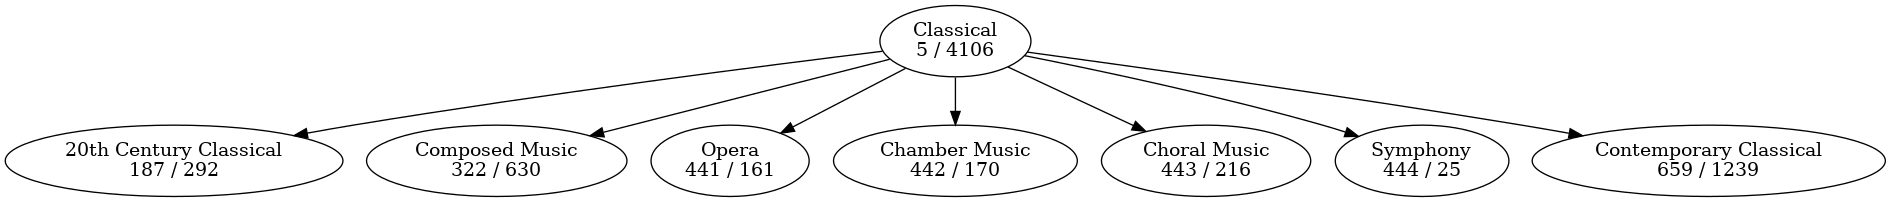

Genere con id: 20


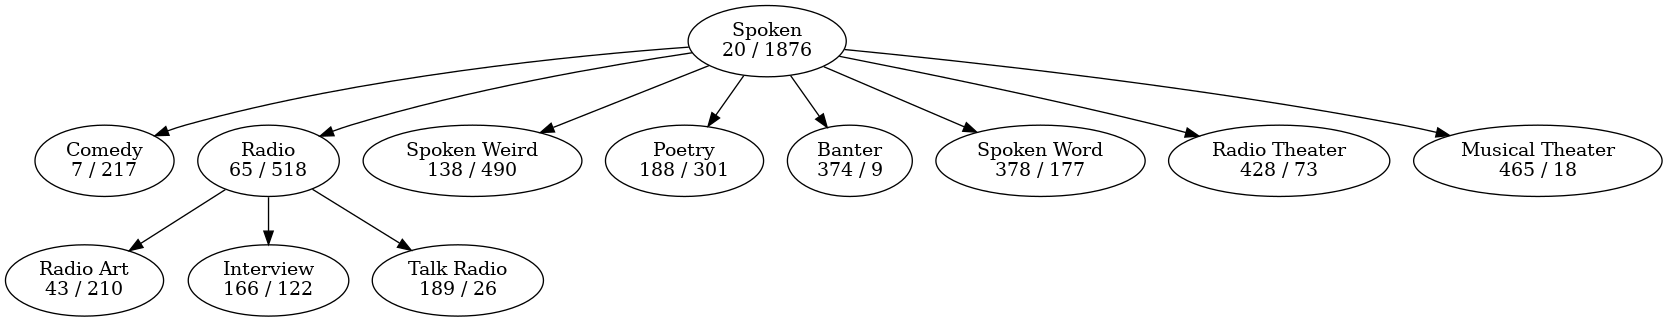

Genere con id: 8


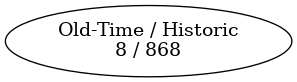

Genere con id: 9


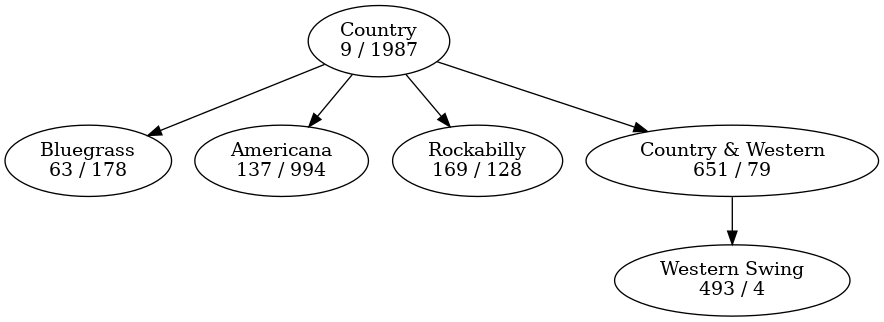

Genere con id: 10


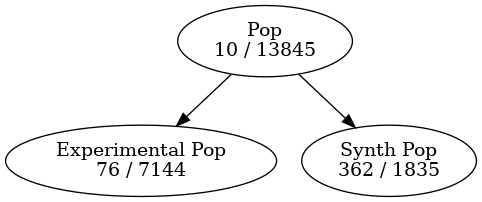

Genere con id: 14


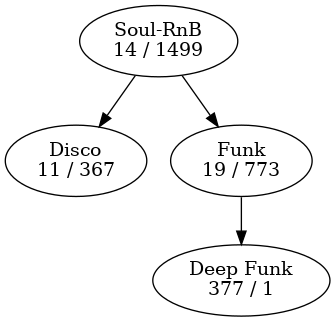

Genere con id: 12


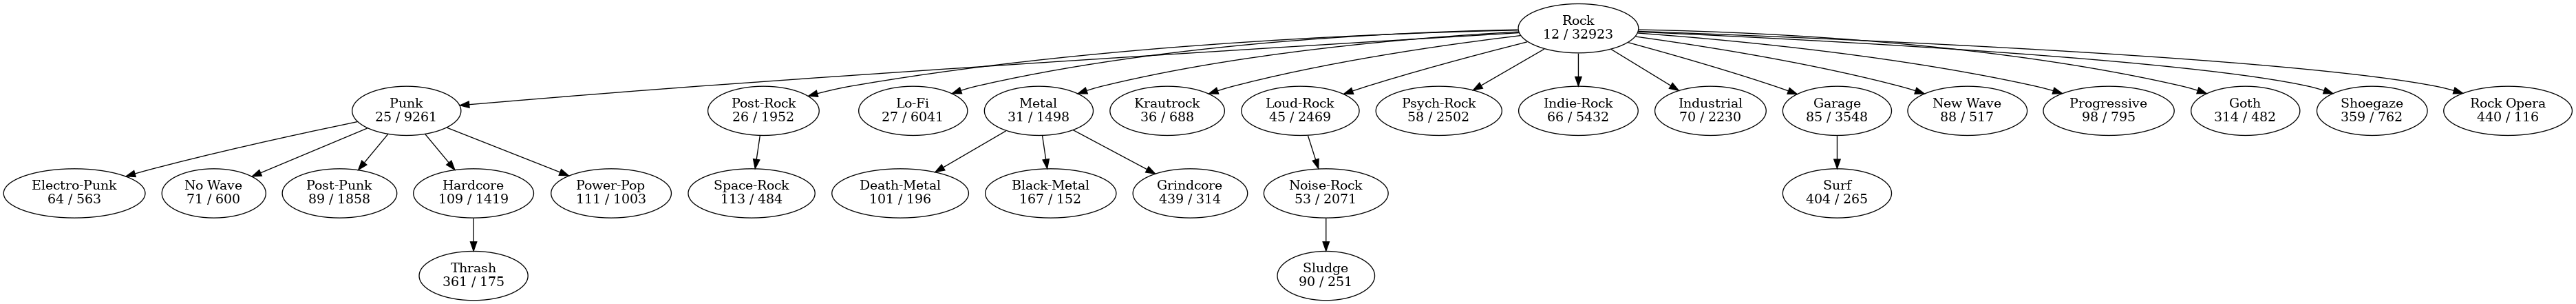

Genere con id: 13


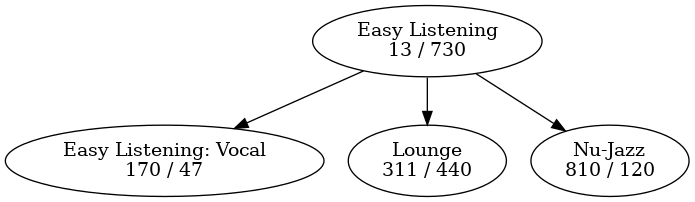

Genere con id: 15


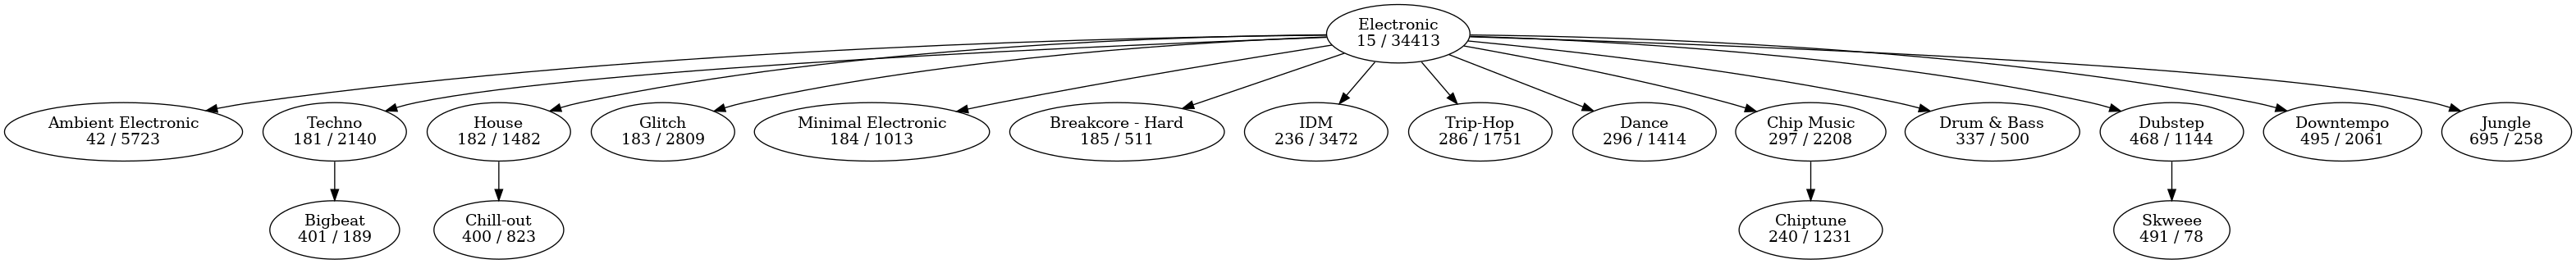

Genere con id: 17


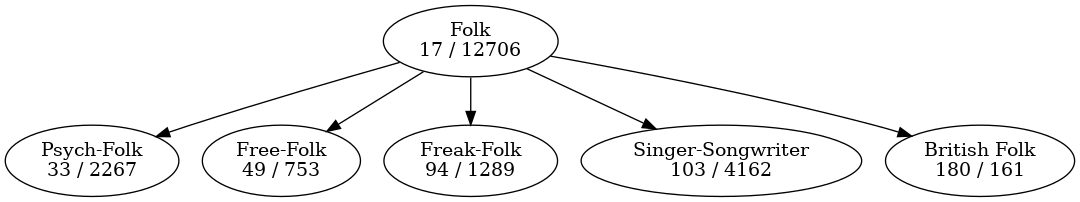

Genere con id: 1235


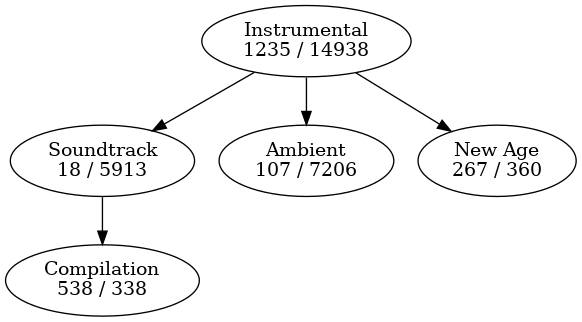

Genere con id: 21


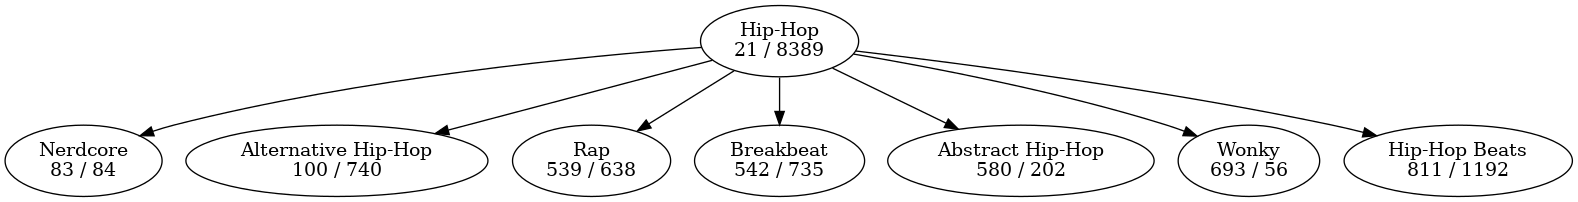

In [17]:
for a in genres.top_level.unique():
    print("Genere con id: "+str(a))
    g = utils.Genres(genres)
    graph = g.create_tree(a, 100000)
    display(ipd.Image(graph.create_png()))




In [63]:
result = tracks.track["date_"].map(lambda x: str(x)[0:4]).value_counts(dropna=False).sort_index()
result.plot(kind="bar")

KeyError: 'date_released'

In [133]:
tracks.head()

album                                                          \
         comments        date_created date_released engineer favorites id   
track_id                                                                    
2               0 2008-11-26 01:44:45    2009-01-05      NaN         4  1   
3               0 2008-11-26 01:44:45    2009-01-05      NaN         4  1   
5               0 2008-11-26 01:44:45    2009-01-05      NaN         4  1   
10              0 2008-11-26 01:45:08    2008-02-06      NaN         4  6   
20              0 2008-11-26 01:45:05    2009-01-06      NaN         2  4   

                                                                           \
                                        information listens producer tags   
track_id                                                                    
2                                           <p></p>    6073      NaN   []   
3                                           <p></p>    6073      NaN   []   
5                                           <p></p>    6073      NaN   []   
10                                              NaN   47632      NaN   []   
20        <p> "spiritual songs" from Nicky Cook</p>    2710      NaN   []   

                                                        artist  \
                         title tracks   type active_year_begin   
track_id                                                         
2         AWOL - A Way Of Life      7  Album        2006-01-01   
3         AWOL - A Way Of Life      7  Album        2006-01-01   
5         AWOL - A Way Of Life      7  Album        2006-01-01   
10           Constant Hitmaker      2  Album               NaT   
20                       Niris     13  Album        1990-01-01   

                                                                             \
         active_year_end                                  associated_labels   
track_id                                                                      
2                    NaT                                                NaN   
3                    NaT                                                NaN   
5                    NaT                                                NaN   
10                   NaT  Mexican Summer, Richie Records, Woodsist, Skul...   
20            2011-01-01                                                NaN   

                                                                      \
                                                        bio comments   
track_id                                                               
2         <p>A Way Of Life, A Collective of Hip-Hop from...        0   
3         <p>A Way Of Life, A Collective of Hip-Hop from...        0   
5         <p>A Way Of Life, A Collective of Hip-Hop from...        0   
10        <p><span style="font-family:Verdana, Geneva, A...        3   
20        <p>Songs written by: Nicky Cook</p>\n<p>VOCALS...        2   

                                                                          \
                date_created favorites id   latitude            location   
track_id                                                                   
2        2008-11-26 01:42:32         9  1  40.058324          New Jersey   
3        2008-11-26 01:42:32         9  1  40.058324          New Jersey   
5        2008-11-26 01:42:32         9  1  40.058324          New Jersey   
10       2008-11-26 01:42:55        74  6        NaN                 NaN   
20       2008-11-26 01:42:52        10  4  51.895927  Colchester England   

                                                                        \
          longitude                                            members   
track_id                                                                 
2        -74.405661  Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...   
3        -74.405661  Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...   
5        -74.405661  Sajje Morocco,Brownbum,ZawidaGod,Custod

In [181]:
tracks.track.duration.describe()

count    106574.000000
mean        277.849100
std         305.518553
min           0.000000
25%         149.000000
50%         216.000000
75%         305.000000
max       18350.000000
Name: duration, dtype: float64

<AxesSubplot:ylabel='Density'>

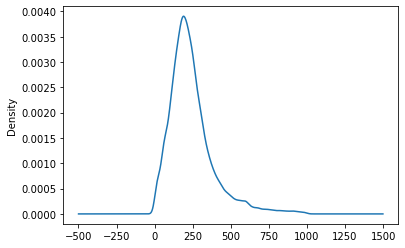

In [43]:
tracks.track.duration[tracks.track.duration < 1000].plot(kind="kde")

<AxesSubplot:ylabel='Density'>

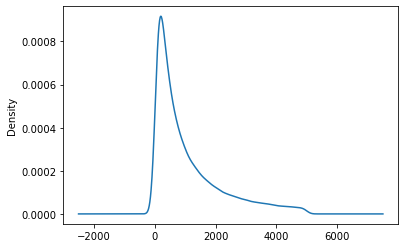

In [50]:
tracks.track.listens[tracks.track.listens < 5000].plot(kind="kde")

In [191]:
tracks.track.duration.value_counts(dropna=False).sort_index()

0        16
1        10
2        13
3        33
4        46
         ..
7372      1
10999     1
11016     1
11030     1
18350     1
Name: duration, Length: 2246, dtype: int64

In [194]:
tracks[tracks.track.language_code == "it"]

album                                                              \
         comments        date_created date_released engineer favorites     id   
track_id                                                                        
10518          -1                 NaT           NaT      NaN        -1     -1   
12923           1 2009-05-14 18:25:56           NaT      NaN         6   3089   
12924           1 2009-05-14 18:25:56           NaT      NaN         6   3089   
12925           1 2009-05-14 18:25:56           NaT      NaN         6   3089   
12926           1 2009-05-14 18:25:56           NaT      NaN         6   3089   
12927           1 2009-05-14 18:25:56           NaT      NaN         6   3089   
20466           0 2009-11-04 02:49:44           NaT      NaN         0   4612   
20467           0 2009-11-04 02:49:44           NaT      NaN         0   4612   
20468           0 2009-11-04 02:49:44           NaT      NaN         0   4612   
20469           0 2009-11-04 02:49:44           NaT      NaN         0   4612   
20470           0 2009-11-04 02:49:44           NaT      NaN         0   4612   
20471           0 2009-11-04 02:49:44           NaT      NaN         0   4612   
20472           0 2009-11-04 02:49:44           NaT      NaN         0   4612   
20473           0 2009-11-04 02:49:44           NaT      NaN         0   4612   
21289           0 2009-11-24 05:33:25           NaT      NaN         0   4738   
21290           0 2009-11-24 05:33:25           NaT      NaN         0   4738   
61494           1 2012-02-29 13:03:58           NaT      NaN         0  11184   
61495           1 2012-02-29 13:03:58           NaT      NaN         0  11184   
61496           1 2012-02-29 13:03:58           NaT      NaN         0  11184   
61497           1 2012-02-29 13:03:58           NaT      NaN         0  11184   
61498           1 2012-02-29 13:03:58           NaT      NaN         0  11184   
61499           1 2012-02-29 13:03:58           NaT      NaN         0  11184   
61500           1 2012-02-29 13:03:58           NaT      NaN         0  11184   
61501           1 2012-02-29 13:03:58           NaT      NaN         0  11184   
61502           1 2012-02-29 13:03:58           NaT      NaN         0  11184   
61503           1 2012-02-29 13:03:58           NaT      NaN         0  11184   
61504           1 2012-02-29 13:03:58           NaT      NaN         0  11184   
61505           1 2012-02-29 13:03:58           NaT      NaN         0  11184   

                                                                              \
                                                information listens producer   
track_id                                                                       
10518                                                   NaN      -1      NaN   
12923     <p>Jody Pou : voice</p>\n<p>Andrea Damiani : l...   13040      NaN   
12924     <p>Jody Pou : voice</p>\n<p>Andrea Damiani : l...   13040      NaN   
12925     <p>Jody Pou : voice</p>\n<p>Andrea Damiani : l...   13040      NaN   
12926     <p>Jody Pou : voice</p>\n<p>Andrea Damiani : l...   13040      NaN   
12927     <p>Jody Pou : voice</p>\n<p>Andrea Damiani : l...   13040      NaN   
20466     <p>ZONA MC, from Italy is the lone Artist to c...    2662      NaN   
20467     <p>ZONA MC, from Italy is the lone Artist to c...    2662      NaN   
20468     <p>ZONA MC, from Italy is the lone Artist to c...    2662      NaN   
20469     <p>ZONA MC, from Italy is the lone Artist to c...    2662      NaN   
20470     <p>ZONA MC, from Italy is the lone Artist to c...    2662      NaN   
20471     <p>ZONA MC, from Italy is the lone Artist to c...    2662      NaN   
20472     <p>ZONA MC, from Italy is the lone Artist to c...    2662      NaN   
20473     <p>ZONA MC, from Italy is the lone Artist to c...    2662      NaN   
21289            <p>Singer and Song Writer, from Italy.</p>     367      NaN   
21290            <p>Singer and Song Writer, from Italy.</p> 

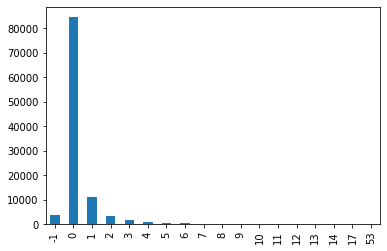

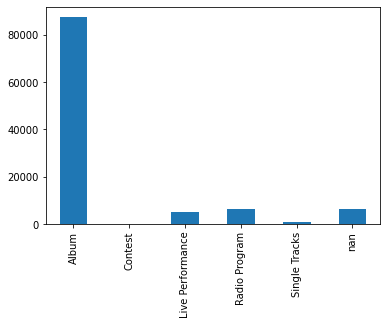

In [120]:
for column in ["comments", "type"]:
    tracks.album[column].value_counts(dropna=False).sort_index().plot(kind='bar')
    plt.show()

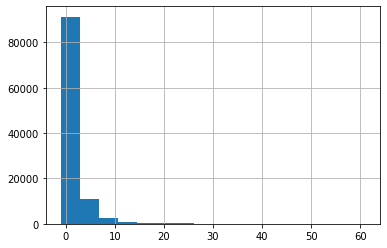

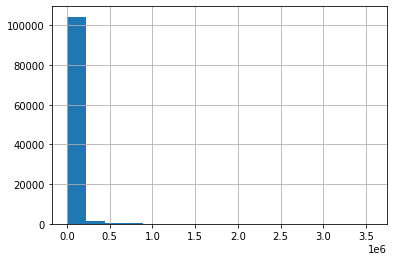

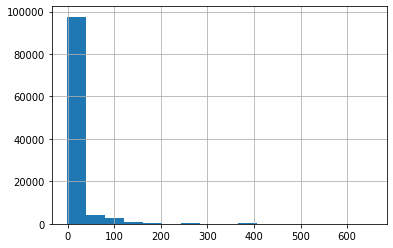

In [121]:
for column in ["favorites", "listens", "tracks"]:
    tracks.album[column].hist(bins=int(np.log2(tracks.album[column].size)))
    plt.show()

<AxesSubplot:>

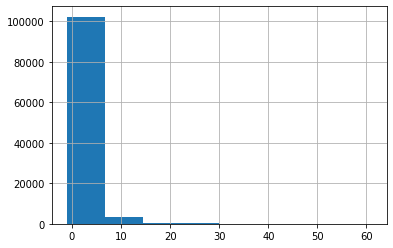

In [122]:
tracks.album["favorites"].hist(bins=8)

In [123]:
tracks.album["listens"].describe()

count    1.065740e+05
mean     3.212031e+04
std      1.478532e+05
min     -1.000000e+00
25%      3.361000e+03
50%      8.982000e+03
75%      2.363500e+04
max      3.564243e+06
Name: listens, dtype: float64

In [124]:
len(tracks.album["producer"].unique())

761

In [125]:
len(tracks.album["engineer"].unique())

623

In [126]:
len(tracks.artist.associated_labels.unique())

755

In [127]:
tracks.artist.name.unique()

array(['AWOL', 'Kurt Vile', 'Nicky Cook', ...,
       'Alex Mason/BlackSunAeon Music', 'AWOTT', 'Spowder'], dtype=object)

In [16]:
#tracks.track['tagsStr'] = str(tracks.track['tags'])

_tracks = tracks.track.copy()

_tracks['tagsStr'] = str(_tracks['tags'])


#for tags in tracks.track.tags:
#    if(len(tags)!=0):
#        print(tags)

In [17]:
unique = list();

for entry in _tracks.tags.values:
    for el in entry:
        if el not in unique:
            #print(el)
            unique.append(el)

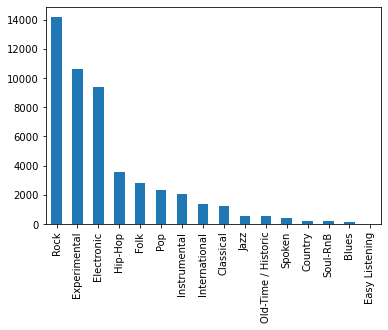

In [28]:
tracks.track.genre_top.value_counts().plot(kind='bar')
plt.show()

In [87]:
genres[genres["#tracks"] > 10000].sort_values('#tracks', ascending=False) 

,#tracks,parent,title,top_level
genre_id,,,,
38,38154,0,Experimental,38
15,34413,0,Electronic,15
12,32923,0,Rock,12
1235,14938,0,Instrumental,1235
10,13845,0,Pop,10
17,12706,0,Folk,17


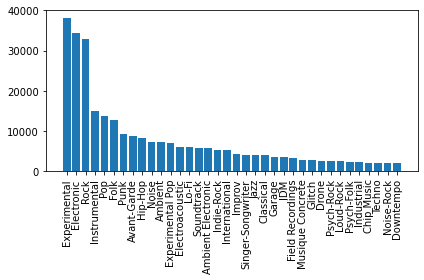

In [53]:
d = genres[genres["#tracks"] > 2000].sort_values('#tracks', ascending=False)  #visualizza solo i generi con più di 2000 traccie
plt.bar(d["title"], d["#tracks"])
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

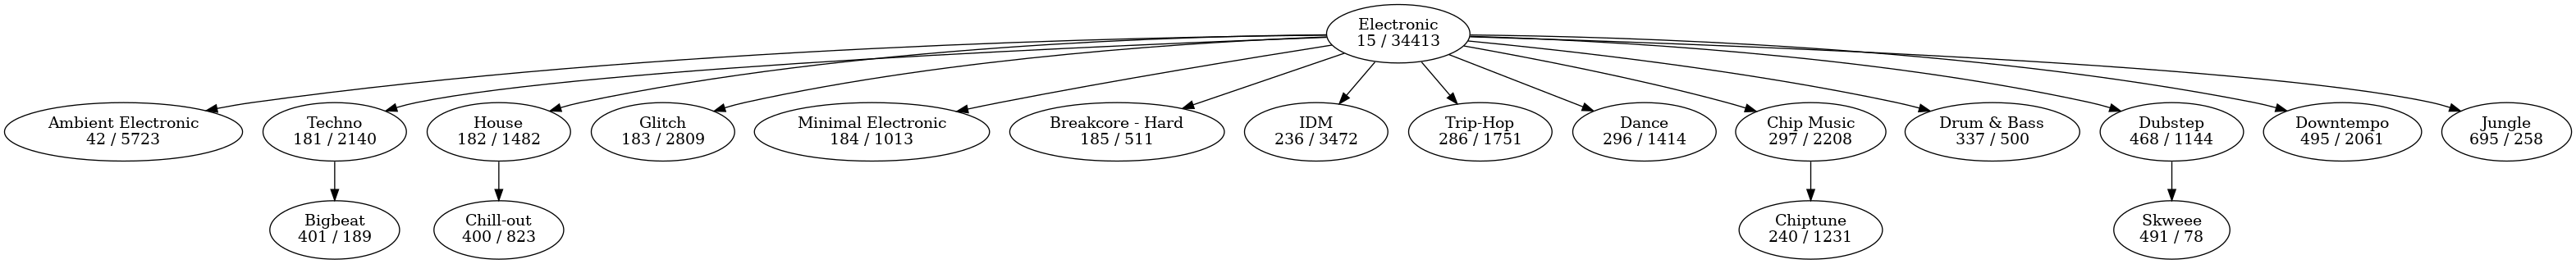

In [53]:
g = utils.Genres(genres)
graph = g.create_tree(15, 3)
ipd.Image(graph.create_png())

In [19]:
genres

,#tracks,parent,title,top_level
genre_id,,,,
1,8693,38,Avant-Garde,38
2,5271,0,International,2
3,1752,0,Blues,3
4,4126,0,Jazz,4
5,4106,0,Classical,5
...,...,...,...,...
1032,60,102,Turkish,2
1060,30,46,Tango,2
1156,26,130,Fado,2


In [24]:
tracks.track.head()

,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,genres_all,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
track_id,,,,,,,,,,,,,,,,,,,,
2,256000,0,NaN,2008-11-26 01:48:12,2008-11-26,168,2,Hip-Hop,[21],[21],NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
3,256000,0,NaN,2008-11-26 01:48:14,2008-11-26,237,1,Hip-Hop,[21],[21],NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
5,256000,0,NaN,2008-11-26 01:48:20,2008-11-26,206,6,Hip-Hop,[21],[21],NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
10,192000,0,Kurt Vile,2008-11-25 17:49:06,2008-11-26,161,178,Pop,[10],[10],NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
20,256000,0,NaN,2008-11-26 01:48:56,2008-01-01,311,0,NaN,"[76, 103]","[17, 10, 76, 103]",NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level


In [42]:
tracks.track[(tracks.track.genre_top == "Spoken") & (tracks.set.subset == "medium")]

,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,genres_all,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
track_id,,,,,,,,,,,,,,,,,,,,
3446,192000,0,NaN,2008-12-04 19:46:40,2008-08-10,108,1,Spoken,[188],"[188, 20]","<p><span style=""font-family: Verdana,Geneva,Ar...",684,en,Attribution-Noncommercial-Share Alike 3.0 Unit...,395,NaN,1,NaN,[],Owed t' Burns 2
3449,192000,0,NaN,2008-12-04 19:46:44,2008-08-10,156,4,Spoken,[188],"[188, 20]","<p><span style=""font-family: Verdana,Geneva,Ar...",2212,en,Attribution-Noncommercial-Share Alike 3.0 Unit...,1440,NaN,4,NaN,[],The Vice President Is Open
3450,192000,0,NaN,2008-12-04 19:46:46,2008-08-10,76,4,Spoken,[188],"[188, 20]","<p><span style=""font-family: Verdana,Geneva,Ar...",1814,en,Attribution-Noncommercial-Share Alike 3.0 Unit...,1227,NaN,5,NaN,[],Bird Poem
6523,192000,0,NaN,2009-02-19 11:17:52,NaT,476,2,Spoken,[20],[20],NaN,5041,en,Attribution-Noncommercial-Share Alike 3.0 Unit...,3226,NaN,1,NaN,"[youth performer, for kids, kid-friendly, chil...",Cheese / I Like Cheese / Cheese is Life (piano...
6584,192000,0,NaN,2009-02-20 08:59:17,NaT,267,0,Spoken,[20],[20],NaN,1094,en,Attribution-Noncommercial-Share Alike 3.0 Unit...,607,NaN,1,NaN,[],Part 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127751,320000,0,NaN,2015-11-12 20:48:23,NaT,101,1,Spoken,"[188, 189, 378]","[65, 20, 378, 188, 189]",NaN,1762,NaN,Attribution-NonCommercial-ShareAlike,1528,NaN,18,NaN,[],Do You Remember?
127752,320000,0,NaN,2015-11-12 20:48:24,NaT,63,0,Spoken,"[188, 189, 378]","[65, 20, 378, 188, 189]",NaN,1117,NaN,Attribution-NonCommercial-ShareAlike,859,NaN,19,NaN,[],Slippage
127753,320000,0,NaN,2015-11-12 20:48:25,NaT,124,0,Spoken,"[188, 189, 378]","[65, 20, 378, 188, 189]",NaN,1249,NaN,Attribution-NonCommercial-ShareAlike,1052,NaN,20,NaN,[],Creationism 1


In [27]:
tracks

album                                                              \
         comments        date_created date_released engineer favorites     id   
track_id                                                                        
2               0 2008-11-26 01:44:45    2009-01-05      NaN         4      1   
3               0 2008-11-26 01:44:45    2009-01-05      NaN         4      1   
5               0 2008-11-26 01:44:45    2009-01-05      NaN         4      1   
10              0 2008-11-26 01:45:08    2008-02-06      NaN         4      6   
20              0 2008-11-26 01:45:05    2009-01-06      NaN         2      4   
...           ...                 ...           ...      ...       ...    ...   
155316          0 2017-03-30 15:20:35    2017-02-17      NaN         0  22940   
155317          0 2017-03-30 15:20:35    2017-02-17      NaN         0  22940   
155318          0 2017-03-30 15:20:35    2017-02-17      NaN         0  22940   
155319          0 2017-03-30 15:20:35    2017-02-17      NaN         0  22940   
155320          0 2017-03-26 16:22:18    2017-03-26      NaN         1  22906   

                                                                     \
                                                information listens   
track_id                                                              
2                                                   <p></p>    6073   
3                                                   <p></p>    6073   
5                                                   <p></p>    6073   
10                                                      NaN   47632   
20                <p> "spiritual songs" from Nicky Cook</p>    2710   
...                                                     ...     ...   
155316    <p>A live performance at Monty Hall on Feb 17,...    1506   
155317    <p>A live performance at Monty Hall on Feb 17,...    1506   
155318    <p>A live performance at Monty Hall on Feb 17,...    1506   
155319    <p>A live performance at Monty Hall on Feb 17,...    1506   
155320                                                  NaN    7481   

                                                                          \
             producer                                               tags   
track_id                                                                   
2                 NaN                                                 []   
3                 NaN                                                 []   
5                 NaN                                                 []   
10                NaN                                                 []   
20                NaN                                                 []   
...               ...                                                ...   
155316    Monty Hall                                                  []   
155317    Monty Hall                                                  []   
155318    Monty Hall                                                  []   
155319    Monty Hall                                                  []   
155320            NaN  [ballad, epic, rockabilly, curse, hex, hard ro...   

                                                                  \
                                  title tracks              type   
track_id                                                           
2                  AWOL - A Way Of Life      7             Album   
3                  AWOL - A Way Of Life      7             Album   
5                  AWOL - A Way Of Life      7             Album   
10                    Constant Hitmaker      2             Album   
20                                Niris     13             Album   
...                                 ...    ...               ...   
155316    Live at Monty Hall, 2/17/2017      6  Live Performance   
155317    Live at Monty Hall, 2/17/2017      6  Live Performance   
155318    Live at Monty Hall, 2/17/2017      6  Live Performance   
1

In [9]:
tracks[tracks.set.subset=='medium'][]

album                                                              \
         comments        date_created date_released        engineer favorites   
track_id                                                                        
3               0 2008-11-26 01:44:45    2009-01-05             NaN         4   
134             0 2008-11-26 01:44:45    2009-01-05             NaN         4   
136             1 2008-11-26 01:49:19    2009-01-07             NaN         0   
139             0 2008-11-26 01:49:57    2009-01-16             NaN         1   
181             0 2008-11-26 01:52:15    2007-04-13             NaN         0   
...           ...                 ...           ...             ...       ...   
155297          0 2017-03-30 09:50:32    2017-03-30             NaN         1   
155298          0 2017-03-30 10:45:13           NaT             NaN         0   
155306          0 2017-03-30 10:45:13           NaT             NaN         0   
155307          0 2017-03-30 12:51:05    2017-03-27  Scott Williams         0   
155314          0 2017-03-30 15:20:35    2017-02-17             NaN         0   

                                                                            \
             id                                        information listens   
track_id                                                                     
3             1                                            <p></p>    6073   
134           1                                            <p></p>    6073   
136          58  <p>A couple of unreleased mp3s from the fellas...    3331   
139          60  <p>A full ensamble of strings, drums, electron...    1304   
181          79  <p>This Human Ear Music reissue compiles a “Be...    1339   
...         ...                                                ...     ...   
155297    22935  <p>The stars will show you the way in this unp...    6196   
155298    22936                                                NaN    2454   
155306    22936                                                NaN    2454   
155307    22937  <p>Scott welcomes Russian revolutionary avant ...    1206   
155314    22940  <p>A live performance at Monty Hall on Feb 17,...    1506   

                                                                            \
                producer tags                                        title   
track_id                                                                     
3                    NaN   []                         AWOL - A Way Of Life   
134                  NaN   []                         AWOL - A Way Of Life   
136                  NaN   []                                          mp3   
139                  NaN   []                        Every Man For Himself   
181                  NaN   []                                Scared Famous   
...                  ...  ...                                          ...   
155297               NaN   []                                       Return   
155298               NaN   []                         Scissors Paper Stone   
155306               NaN   []                         Scissors Paper Stone   
155307    Scott Williams   []  Live at WFMU with Scott Williams, 3/27/2017   
155314       Monty Hall    []                Live at Monty Hall, 2/17/2017   

                                             artist                  \
         tracks              type active_year_begin active_year_end   
track_id                                                              
3             7             Album        2006-01-01             NaT   
134           7             Album        2006-01-01             NaT   
136           4     Single Tracks               NaT             NaT   
139           2             Album        1999-01-01             NaT   
181           1             Album        1996-01-01             NaT   
...         ...               ...               ...             ...   
155297        9             Album               NaT 